In [1]:
library(dplyr)
library(readr)
install.packages("caret")
library(caret)
install.packages("ggplot2")
library(ggplot2)
install.packages("randomForest")
library(randomForest)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggpl

In [2]:
# Instalar y cargar las bibliotecas necesarias
install.packages("googledrive")
library(googledrive)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Autenticarse con Google Drive
drive_auth()

Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=626759b6938a0ad0ec3f416725cc646d&access_type=offline&prompt=consent



In [ ]:
# Especificar el ID del archivo y la ruta de destino
file_id <- "https://drive.google.com/file/d/1WDRKvrZrvSlQa8qNgUCoGwEyepYNm3dz/view?usp=drivesdk"  # Reemplaza este ID con el ID de tu archivo
drive_download(as_id(file_id), path = "archivo.csv", overwrite = TRUE)

In [ ]:
# Leer el archivo CSV desde la URL
urlAge <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/machine_age.csv"
urlMechanic <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/mechanic_antiquity.csv"
df <- read_csv("archivo.csv", show_col_types = FALSE)
df_age <- read_csv(urlAge, show_col_types = FALSE)
df_mechanic <- read_csv(urlMechanic, show_col_types = FALSE)

In [ ]:
summary(df)

In [ ]:
head(df,5)

**LIMPIEZA DE DATOS**

In [ ]:
sapply(df, function(x) sum(is.na(x)))
#Fiabilidad suficiente para continuar con el trabajo

In [ ]:
# Remover el símbolo de dólar y las comas, y convertir a float
df$parts_cost <- as.numeric(gsub("[\\$,()]", "", df$parts_cost))

In [ ]:
# Convertir la columna 'Date' al formato adecuado
df$date <- as.Date(df$date, format="%m/%d/%Y")  # Ajusta el formato según tus datos
# Ordenar el DataFrame por fecha
df <- df %>%
  arrange(date)

In [ ]:
mean(df$downtime_gross < 0)

In [ ]:
# Filtrar registros donde downtimeGross no sea negativo
df <- df %>%
  filter(downtime_gross >= 0)

In [ ]:
mean(df$repair_hours < 0)

In [ ]:
#Eliminar columnas que no seran utilizadas
df <- select(df, -problem_code, -failure_code, -cause_code, -action_code, -pit_coverage, -real_downtime, -waiting_hours)
#Se han eliminado codigos y variables calculadas

In [ ]:
# Filtrar el DataFrame por 'WO Type' igual a 'Corrective Maintenance'
df <- df %>%
  filter(`wo_type` == "Corrective Maintenance")
#Colocar comentario de por qué el filtro, colocar que tecnicas pueden aplicarse y cuales no, colocar en apartado diferente

In [ ]:
# Calcular la diferencia en días entre fechas consecutivas
df <- df %>%
  group_by(equipment) %>%
  mutate(Days_Between_Failures = difftime(date, lag(date), units = "days"))

# Reemplazar los valores NA en Days_Between_Failures
df$Days_Between_Failures[is.na(df$Days_Between_Failures)] <- as.numeric(difftime(df$date[is.na(df$Days_Between_Failures)], as.Date("2023-01-01"), units = "days"))

In [ ]:
# Convertir 'Days_Between_Failures' a numeric
df$Days_Between_Failures <- as.numeric(df$Days_Between_Failures, units = "days")

In [ ]:
#Cambio de nombre de mecánico cuyo nombre está escrito de dos formas
df <- df %>%
  mutate(mechanic = ifelse(mechanic == "GALEAS PEREZ EDWIN ROGELIO", "Edwin Rogelio Galeas Perez", mechanic))

In [ ]:
# Calcular la tabla de frecuencias de cause_desc
freq_cause_desc <- table(df$cause_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_cause <- sort(freq_cause_desc)

# Calcular la frecuencia relativa acumulada
freq_relative_cause <- cumsum(freq_sorted_cause) / sum(freq_sorted_cause)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_cause <- names(freq_sorted_cause[freq_relative_cause < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$cause_desc[df$cause_desc %in% categorias_baja_frecuencia_cause] <- "Misadjusted machine head looper / Enlazador de cabezal desajustado"

In [ ]:
# Calcular la tabla de frecuencias de action_desc
freq_action_desc <- table(df$action_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_action <- sort(freq_action_desc)

# Calcular la frecuencia relativa acumulada
freq_relative_action <- cumsum(freq_sorted_action) / sum(freq_sorted_action)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_action <- names(freq_sorted_action[freq_relative_action < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$action_desc[df$action_desc %in% categorias_baja_frecuencia_action] <- "Adjust machine head looper / Ajustar enlazador de cabezal"

In [ ]:
# Calcular la tabla de frecuencias de operation
freq_operation <- table(df$operation)

# Ordenar las frecuencias de menor a mayor
freq_sorted_operation <- sort(freq_operation)

# Calcular la frecuencia relativa acumulada
freq_relative_operation <- cumsum(freq_sorted_operation) / sum(freq_sorted_operation)

# Definir umbral de frecuencia acumulada
umbral <- 0.1

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_operation <- names(freq_sorted_operation[freq_relative_operation < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$operation[df$operation %in% categorias_baja_frecuencia_operation] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de mechanic
freq_mechanic <- table(df$mechanic)

# Ordenar las frecuencias de menor a mayor
freq_sorted_mechanic <- sort(freq_mechanic)

# Calcular la frecuencia relativa acumulada
freq_relative_mechanic <- cumsum(freq_sorted_mechanic) / sum(freq_sorted_mechanic)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_mechanic <- names(freq_sorted_mechanic[freq_relative_mechanic < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$mechanic[df$mechanic %in% categorias_baja_frecuencia_mechanic] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de base_model
freq_model <- table(df$base_model)

# Ordenar las frecuencias de menor a mayor
freq_sorted_model <- sort(freq_model)

# Calcular la frecuencia relativa acumulada
freq_relative_model <- cumsum(freq_sorted_model) / sum(freq_sorted_model)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_model <- names(freq_sorted_model[freq_relative_model < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$base_model[df$base_model %in% categorias_baja_frecuencia_model] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de problem_desc
freq_problem <- table(df$problem_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_problem <- sort(freq_problem)

# Calcular la frecuencia relativa acumulada
freq_relative_problem <- cumsum(freq_sorted_problem) / sum(freq_sorted_problem)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_problem <- names(freq_sorted_problem[freq_relative_problem < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$problem_desc[df$problem_desc %in% categorias_baja_frecuencia_problem] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de failure_desc
freq_failure <- table(df$failure_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_failure <- sort(freq_failure)

# Calcular la frecuencia relativa acumulada
freq_relative_failure <- cumsum(freq_sorted_failure) / sum(freq_sorted_failure)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_failure <- names(freq_sorted_failure[freq_relative_failure < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$failure_desc[df$failure_desc %in% categorias_baja_frecuencia_failure] <- "Otros"

In [ ]:
#Convertir horas a minutos
df$downtime_gross <-df$downtime_gross*60

In [ ]:
#Convertir horas a minutos
df$repair_hours <-df$repair_hours*60

**ANALISIS DE VARIABLES**

In [ ]:
dim(df)

**Variable "Operación"**

In [ ]:
# Calcular la frecuencia de cada operación
operation_freq <- df %>%
  group_by(operation) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
operation_freq <- operation_freq %>%
  mutate(relative_freq = count / sum(count))

operation_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
operation_freq <- operation_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=8)

ggplot(operation_freq, aes(y = reorder(operation, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +
  labs(title = "Frecuencia relativa de operaciones con más fallos",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(size = 12))

**Variable "problem_desc"**

In [ ]:
# Calcular la frecuencia de problemas de maquinaria
problem_freq <- df %>%
  group_by(problem_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
problem_freq <- problem_freq %>%
  mutate(relative_freq = count / sum(count))

problem_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
problem_freq <- problem_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=6)

ggplot(problem_freq, aes(y = reorder(problem_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +
  labs(title = "Frecuencia relativa de problemas de maquinaria",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(size = 12))

**Variable "failure_desc"**

In [ ]:
# Calcular la frecuencia de fallos de maquinaria
failure_freq <- df %>%
  group_by(failure_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
failure_freq <- failure_freq %>%
  mutate(relative_freq = count / sum(count))

failure_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
failure_freq <- failure_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=6)

ggplot(failure_freq, aes(y = reorder(failure_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de fallos",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(size = 12))
        #Colocar top 3 con frecuencia relativa

**Variable "cause_desc"**

In [ ]:
# Calcular la frecuencia de causas de fallo
cause_freq <- df %>%
  group_by(cause_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
cause_freq <- cause_freq %>%
  mutate(relative_freq = count / sum(count))

cause_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
cause_freq <- cause_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=12)

ggplot(cause_freq, aes(y = reorder(cause_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de causa de fallos",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(size = 12))

**Variable "action_desc"**

In [ ]:
# Calcular la frecuencia de acciones correctivas
action_freq <- df %>%
  group_by(action_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
action_freq <- action_freq %>%
  mutate(relative_freq = count / sum(count))

action_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
action_freq <- action_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=12)

ggplot(action_freq, aes(y = reorder(action_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de acciones correctivas",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(size = 12))

**Variable "mechanic"**

In [ ]:
# Calcular la frecuencia de fallos resueltos por mecánicos
mechanic_freq <- df %>%
  group_by(mechanic) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
mechanic_freq <- mechanic_freq %>%
  mutate(relative_freq = count / sum(count))

mechanic_freq

**Variable "repair_hours"**

In [ ]:
# Crear el boxplot de repair_hours
ggplot(df, aes(y = repair_hours)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de repair time',
       y = 'Minutos de reparación') +
  theme_minimal()

In [ ]:
# Crear el boxplot de repair_hours y ajustar los límites del eje y
ggplot(df, aes(y = repair_hours)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de repair time', y = 'Minutos de reparación') +
  theme_minimal() +
  coord_cartesian(ylim = c(0, 130))

In [ ]:
# Calcular los outliers
outlier_threshold <- quantile(df$repair_hours, 0.95)

# Identificar outliers
df$outlier <- ifelse(df$repair_hours > outlier_threshold, TRUE, FALSE)

# Convertir Date a formato de fecha
df$date <- as.Date(df$date)

# Agrupar por año y mes, y contar la frecuencia de outliers
df_outliers <- df %>%
  mutate(Year = year(date),
         Month = month(date, label = TRUE)) %>%
  group_by(Year, Month) %>%
  summarise(Outliers = sum(outlier), .groups = 'drop')

# Crear un gráfico de barras de la frecuencia de outliers por mes y año
ggplot(df_outliers, aes(x = Month, y = Outliers, fill = as.factor(Year))) +
  geom_bar(stat = "identity", position = "dodge", color = 'black') +
  labs(title = 'Frecuencia de Outliers por Mes y Año',
       x = 'Mes',
       y = 'Cantidad de Outliers',
       fill = 'Año') +
  theme_minimal()

**Variable "parts cost"**

In [ ]:
# Crear el boxplot de costo de partes
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal()

In [ ]:
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal() +
  ylim(0, 50)

**ANALISIS DE VARIABLE OBJETIVO "DOWNTIME GROSS"**

In [ ]:
# Histograma de 'downtimeGross'
hist_downtimeGross <- ggplot(df, aes(x = downtime_gross)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Downtime Bruto (minutos)",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_downtimeGross)

In [ ]:
# Crear el boxplot de downtime gross
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal()

In [ ]:
# Crear el boxplot de downtime gross
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() + coord_cartesian(ylim = c(0, 300))

In [ ]:
# Calcular los outliers
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Convertir Date a formato de fecha
df$date <- as.Date(df$date)

# Agrupar por año y mes, y contar la frecuencia de outliers
df_outliers <- df %>%
  mutate(Year = year(date),
         Month = month(date, label = TRUE)) %>%
  group_by(Year, Month) %>%
  summarise(Outliers = sum(outlier), .groups = 'drop')

# Crear un gráfico de barras de la frecuencia de outliers por mes y año
ggplot(df_outliers, aes(x = Month, y = Outliers, fill = as.factor(Year))) +
  geom_bar(stat = "identity", position = "dodge", color = 'black') +
  labs(title = 'Frecuencia de Outliers de Downtime Gross por Mes y Año',
       x = 'Mes',
       y = 'Cantidad de Outliers',
       fill = 'Año') +
  theme_minimal()

**GLM INICIAL PARA PREDECIR DOWNTIME**



In [49]:
df <- select(df, -wo_type, -outlier)
#Comparar con un glm

In [50]:
head(df,5)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,repair_hours,changed_pcs,Days_Between_Failures
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.00,10,0,2
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.20,60,1,2
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.20,60,1,0
1027243,SET SLEEVE,VC2700,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Oil leak in machine head / Fuga de aceite lubricante en cabezal,Fix machine head oil leak / Corregir fuga de aceite en cabezal,Otros,2023-01-03,30,60.69,30,1,2
1027243,SET SLEEVE,VC2700,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Oil leak in machine head / Fuga de aceite lubricante en cabezal,Fix machine head oil leak / Corregir fuga de aceite en cabezal,Otros,2023-01-03,30,60.69,30,1,0


In [51]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data1 <- df[trainIndex, ]
validation_data1 <- df[validationIndex, ]
test_data1 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data1), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data1), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data1), "\n")

Dimensiones del conjunto de entrenamiento:  95100 14 
Dimensiones del conjunto de validación:  27171 14 
Dimensiones del conjunto de prueba:  13587 14 


In [52]:
# Inicializar y ajustar el modelo de regresión lineal
#Dividir en entrenamiento, test, validación por ejemplo 70,20,10
start_time <- Sys.time()
model1 <- glm(downtime_gross~. -equipment -downtime_gross -repair_hours -Days_Between_Failures -date -changed_pcs, data = train_data1)
end_time <- Sys.time()
training_time1 <- end_time - start_time
training_time1
# Resumen del modelo
summary(model1)

Time difference of 8.396303 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    repair_hours - Days_Between_Failures - date - changed_pcs, 
    data = train_data1)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 76.618674
operationBARTACK                                                                           -12.566912
operationBIND ARM                                                                          -22.410193
operationBIND LEG                                                                           -7.504769
operationBIND NECK                                                                         -23.491327
operationCLOSE SLEEVE                                                                       15.000993
operationFLAT LOCK                                                                         -15.735625
operation

In [53]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model1, newdata = validation_data1)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data1$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  92.86019 
Validation MAE:  61.07779 
Validation R-squared:  0.1546213 


In [54]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model1, newdata = test_data1)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data1$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  92.49887 
Test MAE:  60.97908 
Test R-squared:  0.1703375 


**CALCULO DE VARIABLES PARA MEJORA DEL AJUSTE**

In [55]:
#Calcular los fallos acumulativos
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Failure_Count = row_number())

In [56]:
# Calcular la mediana de tiempo de reparación
df <- df %>%
  group_by(equipment) %>%
  mutate(Median_Repair_Time = median(repair_hours, na.rm = TRUE))

In [57]:
# Calcular el costo acumulado de mantenimiento
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Maintenance_Cost = cumsum(parts_cost))

In [58]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data2 <- df[trainIndex, ]
validation_data2 <- df[validationIndex, ]
test_data2 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data2), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data2), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data2), "\n")

Dimensiones del conjunto de entrenamiento:  95100 17 
Dimensiones del conjunto de validación:  27171 17 
Dimensiones del conjunto de prueba:  13587 17 


**GLM PARA PREDECIR DOWNTIME CON MAS VARIABLES**

In [59]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model2 <- glm(downtime_gross~. -equipment -downtime_gross -repair_hours -date -changed_pcs, data = train_data2)
end_time <- Sys.time()
training_time2 <- end_time - start_time
training_time2
# Resumen del modelo
summary(model2)

Time difference of 7.763751 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    repair_hours - date - changed_pcs, data = train_data2)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 4.187e+01
operationBARTACK                                                                           -1.810e+01
operationBIND ARM                                                                          -2.148e+01
operationBIND LEG                                                                          -1.127e+01
operationBIND NECK                                                                         -1.891e+01
operationCLOSE SLEEVE                                                                       1.422e+01
operationFLAT LOCK                                                                         -1.467e+01
operationFLAT SEAM                    

In [60]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model2, newdata = validation_data2)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data2$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  90.81425 
Validation MAE:  59.22341 
Validation R-squared:  0.1914624 


In [61]:
# Predecir con el conjunto de prueba (ya calculado, pero repitiendo para claridad)
test_predictions <- predict(model2, newdata = test_data2)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data2$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  90.50203 
Test MAE:  58.94374 
Test R-squared:  0.2057719 


**MODELO AGREGANDO LA VARIABLE "MACHINE AGE"**

In [62]:
# Renombrar la columna 'Equipment' a 'equipment' en df_age
df_age <- df_age %>% rename(equipment = Equipment)

In [63]:
df_merged <- df %>%
  left_join(df_age %>% select(equipment, Age), by = "equipment")

In [64]:
head(df_merged,3)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,repair_hours,changed_pcs,Days_Between_Failures,Cumulative_Failure_Count,Median_Repair_Time,Cumulative_Maintenance_Cost,Age
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.0,10,0,2,1,30,51.0,26
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,60,1,2,1,60,19.2,23
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,60,1,0,2,60,38.4,23


In [65]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data3 <- df_merged[trainIndex, ]
validation_data3 <- df_merged[validationIndex, ]
test_data3 <- df_merged[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data3), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data3), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data3), "\n")

Dimensiones del conjunto de entrenamiento:  95100 18 
Dimensiones del conjunto de validación:  27171 18 
Dimensiones del conjunto de prueba:  13587 18 


In [66]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model3 <- glm(downtime_gross~. -equipment -downtime_gross -repair_hours -date -changed_pcs, data = train_data3)
end_time <- Sys.time()
training_time3 <- end_time - start_time
training_time3
# Resumen del modelo
summary(model3)

Time difference of 7.753242 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    repair_hours - date - changed_pcs, data = train_data3)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 3.223e+01
operationBARTACK                                                                           -1.660e+01
operationBIND ARM                                                                          -2.101e+01
operationBIND LEG                                                                          -1.046e+01
operationBIND NECK                                                                         -1.805e+01
operationCLOSE SLEEVE                                                                       1.504e+01
operationFLAT LOCK                                                                         -1.287e+01
operationFLAT SEAM                    

In [67]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model3, newdata = validation_data3)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data3$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  90.78019 
Validation MAE:  59.17783 
Validation R-squared:  0.1920688 


In [68]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model3, newdata = test_data3)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data3$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  90.46269 
Test MAE:  58.92832 
Test R-squared:  0.2064621 


**MODELO AGREGANDO LA VARIABLE "MECHANIC ANTIQUITY"**

In [69]:
# Primero, calcula la media de antiquity
mean_antiquity <- mean(df_mechanic$antiquity, na.rm = TRUE)

# Realiza el left join y luego reemplaza los NA en antiquity con la media calculada
df_merged2 <- df_merged %>%
  left_join(df_mechanic %>% select(mechanic, antiquity), by = "mechanic") %>%
  mutate(antiquity = ifelse(is.na(antiquity), mean_antiquity, antiquity))

In [70]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged2)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data4 <- df_merged2[trainIndex, ]
validation_data4 <- df_merged2[validationIndex, ]
test_data4 <- df_merged2[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data4), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data4), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data4), "\n")

Dimensiones del conjunto de entrenamiento:  95100 19 
Dimensiones del conjunto de validación:  27171 19 
Dimensiones del conjunto de prueba:  13587 19 


In [71]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model4 <- glm(downtime_gross~. -equipment -downtime_gross -repair_hours -date -changed_pcs, data = train_data4)
end_time <- Sys.time()
training_time4 <- end_time - start_time
training_time4
# Resumen del modelo
summary(model4)

Time difference of 8.142357 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    repair_hours - date - changed_pcs, data = train_data4)

Coefficients: (1 not defined because of singularities)
                                                                                             Estimate
(Intercept)                                                                                 3.223e+01
operationBARTACK                                                                           -1.660e+01
operationBIND ARM                                                                          -2.101e+01
operationBIND LEG                                                                          -1.046e+01
operationBIND NECK                                                                         -1.805e+01
operationCLOSE SLEEVE                                                                       1.504e+01
operationFLAT LOCK                                                                         -1.287e+

In [72]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model4, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  90.78019 
Validation MAE:  59.17783 
Validation R-squared:  0.1920688 


In [73]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model4, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  90.46269 
Test MAE:  58.92832 
Test R-squared:  0.2064621 


**AGREGANDO LA VARIABLE "CHANGED_PCS"**

In [74]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model5 <- glm(downtime_gross~. -equipment -downtime_gross -repair_hours -date -antiquity, data = train_data4)
end_time <- Sys.time()
training_time5 <- end_time - start_time
training_time5
# Resumen del modelo
summary(model5)

Time difference of 8.157821 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    repair_hours - date - antiquity, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 4.575e+01
operationBARTACK                                                                           -1.619e+01
operationBIND ARM                                                                          -1.722e+01
operationBIND LEG                                                                          -1.156e+01
operationBIND NECK                                                                         -1.760e+01
operationCLOSE SLEEVE                                                                       5.839e+00
operationFLAT LOCK                                                                         -1.179e+01
operationFLAT SEAM                      

In [75]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model5, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  66.59544 
Validation MAE:  39.72343 
Validation R-squared:  0.5652083 


In [76]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model5, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.26446 
Test MAE:  39.56126 
Test R-squared:  0.5742155 


**IMPLEMENTACION DE FRONTWARD**

In [77]:
sapply(df_merged2, function(x) sum(is.na(x)))

equipment                   operation 
                          0                           0 
                 base_model                problem_desc 
                          0                           0 
               failure_desc                  cause_desc 
                          0                           0 
                action_desc                    mechanic 
                          0                           0 
                       date              downtime_gross 
                          0                           0 
                 parts_cost                repair_hours 
                          0                           0 
                changed_pcs       Days_Between_Failures 
                          0                           0 
   Cumulative_Failure_Count          Median_Repair_Time 
                          0                           0 
Cumulative_Maintenance_Cost                         Age 
                          0                           0 
                  antiquity 
                          0

In [78]:
# Realizar frontward elimination
model_null <- lm(downtime_gross ~ 1, data = train_data4)
model_forward <- step(model_null,
                      scope = list(lower = model_null, upper = model5),
                      direction = "forward")
model_forward$anova

Start:  AIC=879713.1
downtime_gross ~ 1

                              Df Sum of Sq       RSS    AIC
+ changed_pcs                  1 500060218 489789987 812805
+ mechanic                    85 132541098 857309106 866212
+ Median_Repair_Time           1  96825405 893024800 869926
+ operation                   25  49834731 940015474 874851
+ base_model                  22  38469265 951380939 875987
+ action_desc                 28  27301122 962549082 877109
+ cause_desc                  28  25936370 963913834 877244
+ problem_desc                 2  23905344 965944861 877392
+ parts_cost                   1   9364447 980485758 878811
+ failure_desc                 3   7565519 982284685 878989
+ Age                          1   5831346 984018859 879153
+ Days_Between_Failures        1   3883037 985967168 879341
+ Cumulative_Maintenance_Cost  1   3396562 986453643 879388
+ Cumulative_Failure_Count     1   1080976 988769228 879611
<none>                                     989850205 879713

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,95099,989850205,879713.1
+ changed_pcs,-1,5.000602e+08,95098,489789987,812805.0
+ mechanic,-85,5.599183e+07,95013,433798158,801430.1
+ operation,-25,4.665530e+06,94988,429132629,800451.7
+ Median_Repair_Time,-1,1.155188e+06,94987,427977441,800197.4
+ cause_desc,-28,1.040841e+06,94959,426936600,800021.8
+ problem_desc,-2,6.308255e+05,94957,426305775,799885.2
+ action_desc,-28,5.663970e+05,94929,425739378,799814.8
+ base_model,-22,4.770831e+05,94907,425262295,799752.1


In [79]:
formula = as.formula("downtime_gross ~ changed_pcs + mechanic + operation + Median_Repair_Time +
    cause_desc + Cumulative_Maintenance_Cost + base_model + Days_Between_Failures +
    failure_desc + problem_desc + action_desc + Age + Cumulative_Failure_Count")

In [80]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model6 <- glm(formula = formula, data = train_data4)
end_time <- Sys.time()
training_time6 <- end_time - start_time
training_time6
# Resumen del modelo
summary(model6)

Time difference of 7.875474 secs


Call:
glm(formula = formula, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 45.702499
changed_pcs                                                                                 54.054235
mechanicAdalberto Jeremias Rodriguez Zometa                                                -23.643957
mechanicAlfonso Escobar                                                                    -31.847855
mechanicAnthony Murillo                                                                    -18.882954
mechanicAntony Ulloa                                                                       -15.205801
mechanicCain Alfredo Ramirez                                                                -0.326482
mechanicCarlos Alberto Alfaro Salamanca                                                     21.792812
mechanicCARLOS CA

**MODELO RANDOM FOREST**

In [81]:
# Entrenar el modelo de Random Forest
start_time <- Sys.time()
model_rf <- randomForest(downtime_gross~. -equipment -downtime_gross -repair_hours -date -antiquity, data = train_data4, importance = TRUE)
end_time <- Sys.time()
training_time7 <- end_time - start_time
training_time7
# Ver el resumen del modelo
print(model_rf)

Time difference of 1.341849 hours


Call:
 randomForest(formula = downtime_gross ~ . - equipment - downtime_gross -      repair_hours - date - antiquity, data = train_data4, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 3297.395
                    % Var explained: 68.32


In [82]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model_rf, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  56.99142 
Validation MAE:  32.99628 
Validation R-squared:  0.681572 


In [83]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model_rf, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  57.25226 
Test MAE:  33.12454 
Test R-squared:  0.6821561 


In [85]:
residuals <- test_data4$downtime_gross - test_predictions

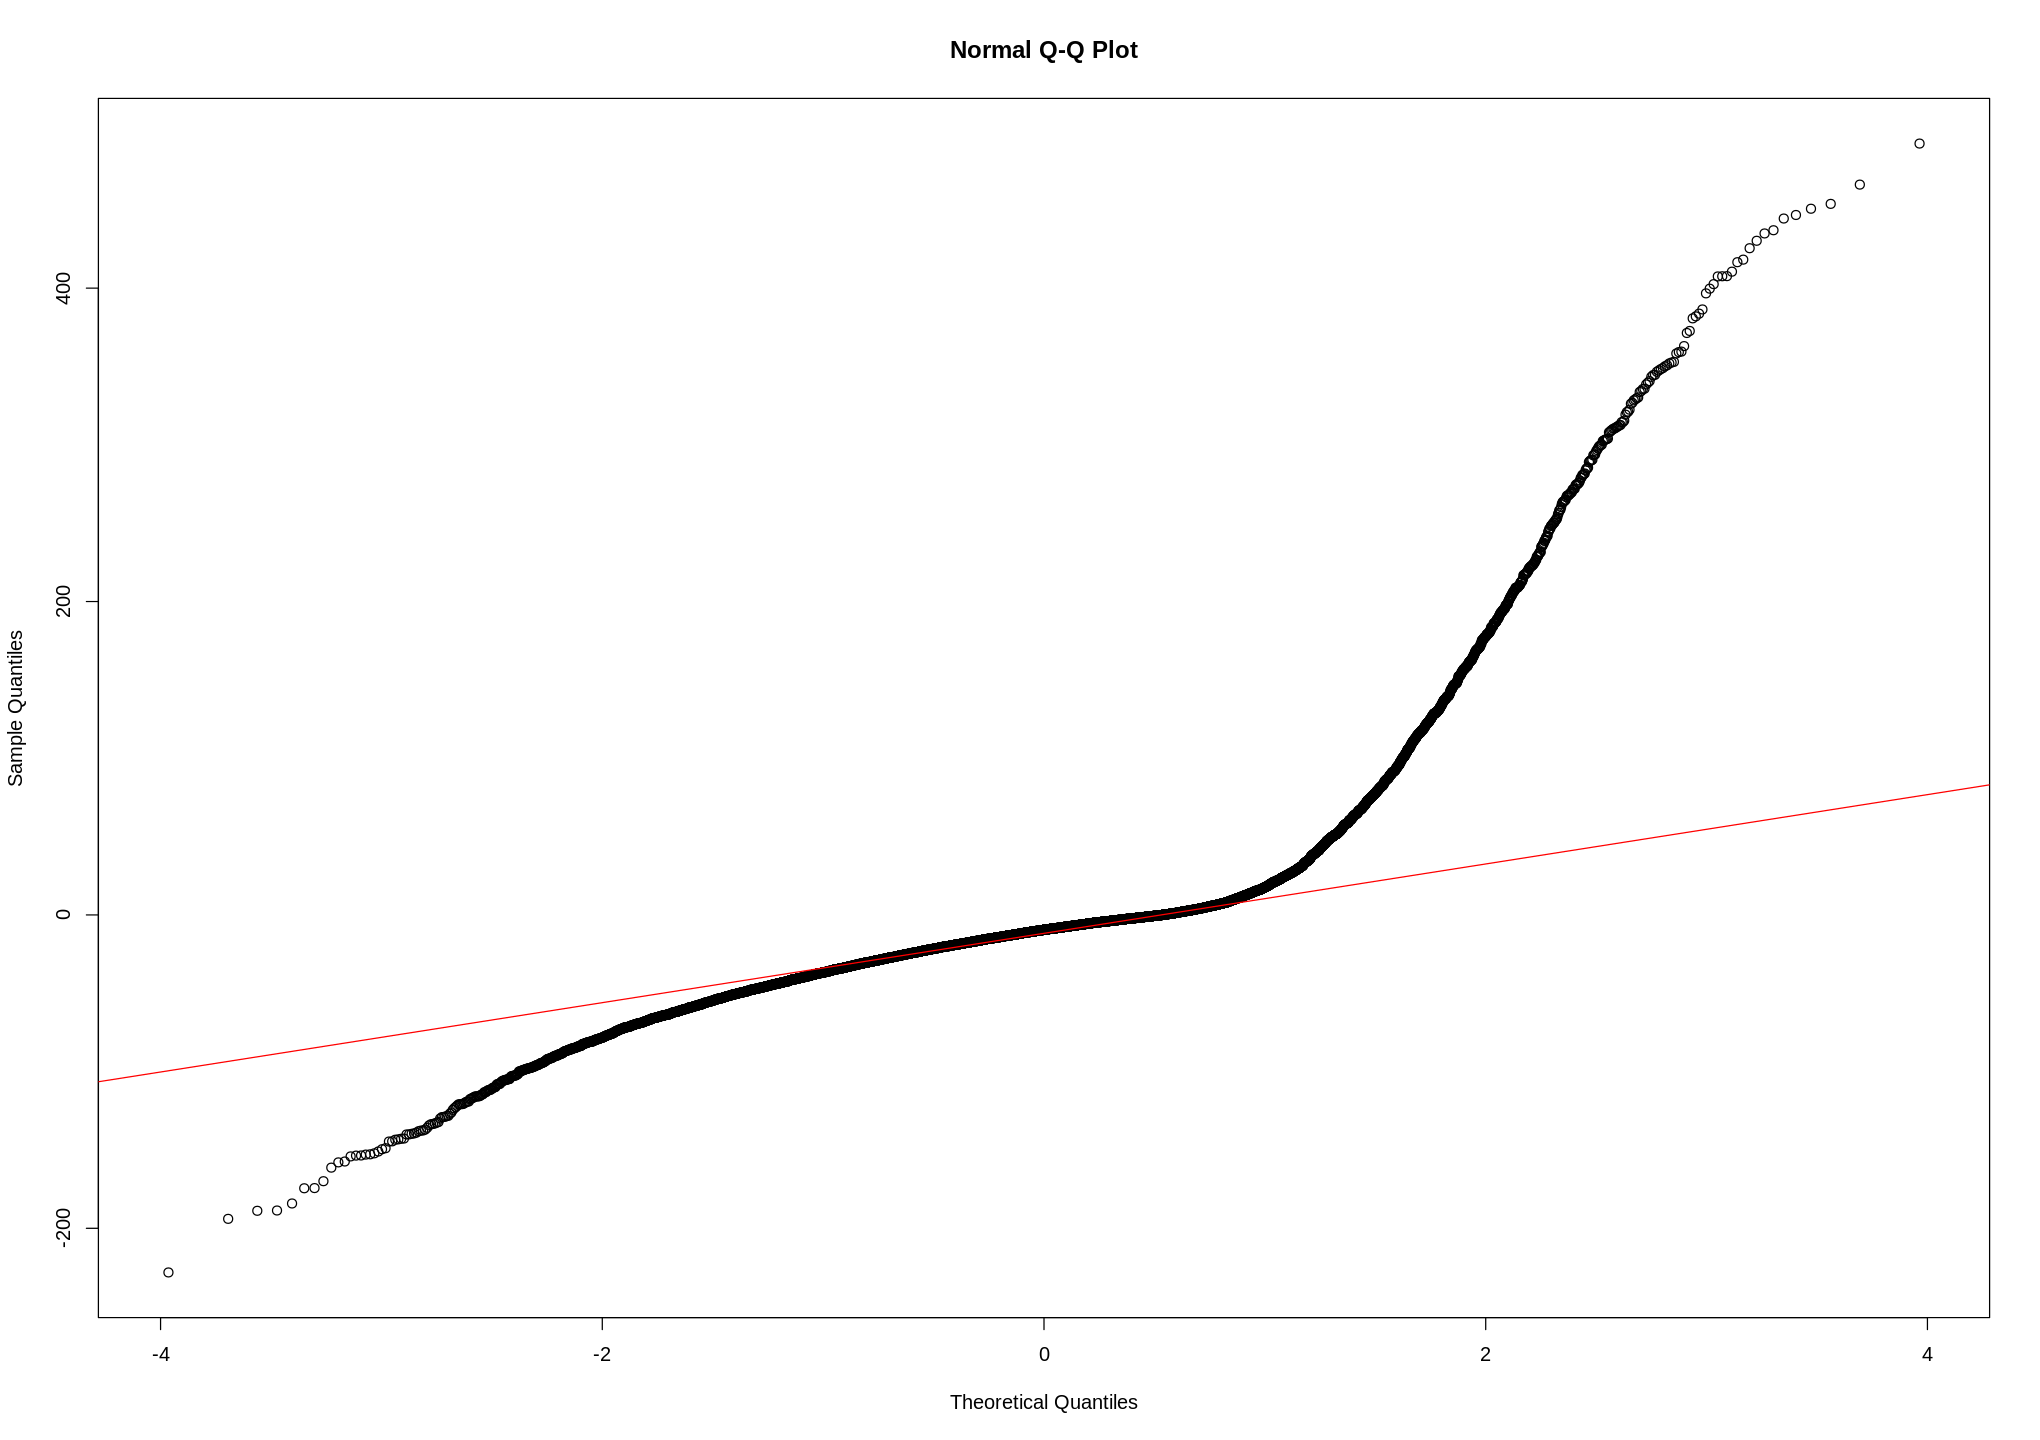

In [86]:
# Crear el Q-Q plot de los residuos en la escala logarítmica
qqnorm(residuals)
qqline(residuals, col = "red")

,%IncMSE,IncNodePurity
operation,69.930816,32966462
base_model,86.812119,28054710
problem_desc,91.909836,17118508
failure_desc,82.935769,15256839
cause_desc,80.297373,29377195
action_desc,90.255072,28389709
mechanic,127.851967,48508852
parts_cost,49.206331,29211751
changed_pcs,415.230638,442615046
Days_Between_Failures,9.231428,29772638


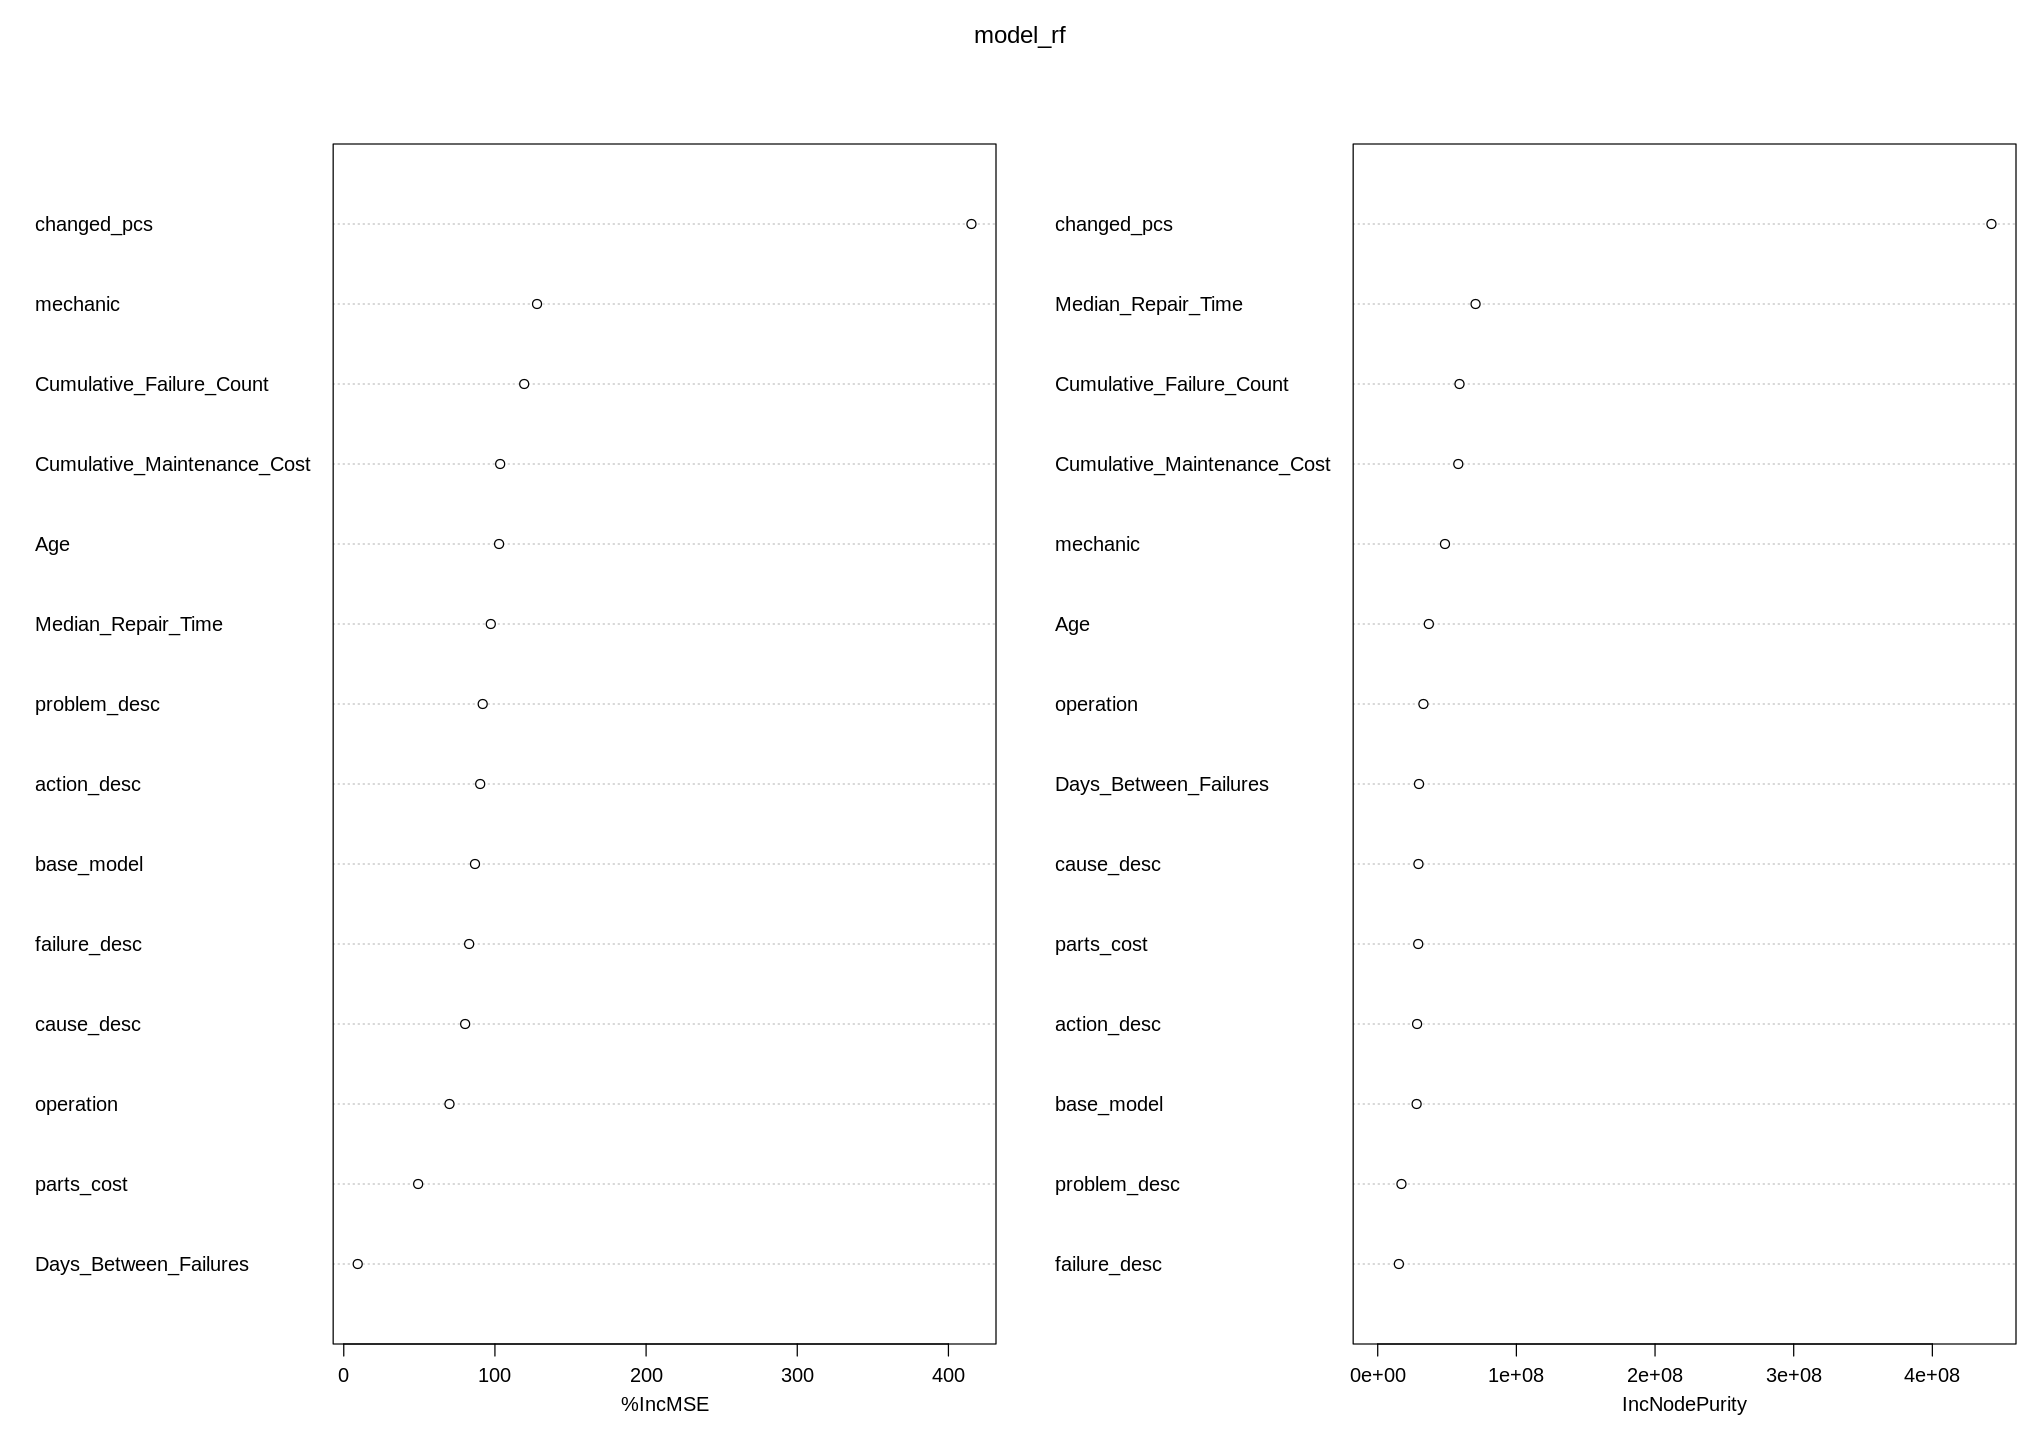

In [87]:
# Ver la importancia de las variables
importance(model_rf)
varImpPlot(model_rf)

In [88]:
install.packages("nortest")
library(nortest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [89]:
ad_test <- ad.test(residuals)
print(ad_test)


	Anderson-Darling normality test

data:  residuals
A = 1044, p-value < 2.2e-16



In [90]:
formula2 = as.formula("downtime_gross ~ changed_pcs*mechanic + operation + Median_Repair_Time +
    cause_desc + action_desc + Cumulative_Maintenance_Cost + problem_desc +
    failure_desc + base_model + Days_Between_Failures +
    Age + Cumulative_Failure_Count")

In [91]:
# Inicializar y ajustar el modelo de regresión lineal
# Medir el tiempo de entrenamiento
start_time <- Sys.time()
model7 <- glm(formula = formula2, data = train_data4)
end_time <- Sys.time()
training_time8 <- end_time - start_time
training_time8
# Resumen del modelo
summary(model7)

Time difference of 14.49831 secs


Call:
glm(formula = formula2, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 4.638e+01
changed_pcs                                                                                 5.280e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                -1.941e+01
mechanicAlfonso Escobar                                                                    -3.667e+01
mechanicAnthony Murillo                                                                    -1.623e+01
mechanicAntony Ulloa                                                                       -1.581e+01
mechanicCain Alfredo Ramirez                                                               -2.762e+00
mechanicCarlos Alberto Alfaro Salamanca                                                     2.199e+01
mechanicCARLOS C

In [92]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model7, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.19022 
Test MAE:  39.14277 
Test R-squared:  0.5751689 


In [93]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model7, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  66.50624 
Validation MAE:  39.35439 
Validation R-squared:  0.5663724 
